In [2]:
from pytorch3d.io import load_obj
path = "/home/borth/sketch2shape/data/siamese_chair_medium/1b5ab441fb8e3b1b450621b513a975bb/model_normalized.obj"
 = load_obj(path, load_textures=False)

In [176]:
obj = load_objs_as_meshes([path])

/home/borth/miniconda3/envs/pytorch3d/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:548: UserWarning:

Mtl file does not exist: /home/borth/sketch2shape/data/siamese_chair_medium/1b5ab441fb8e3b1b450621b513a975bb/model_normalized.mtl



In [188]:
import trimesh
import pyrender

mesh = trimesh.load(path, force="mash")
# Create a pyrender scene
scene = pyrender.Scene()

# Convert trimesh to pyrender.Mesh
mesh_pyrender = pyrender.Mesh.from_trimesh(mesh)

# Add the mesh to the scene
scene.add(mesh_pyrender)

# Set up a camera
camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0, aspectRatio=1.0)
scene.add(camera, pose=np.eye(4))

# Set up a light
light = pyrender.SpotLight(color=np.ones(3), intensity=3.0, innerConeAngle=np.pi/16.0)
scene.add(light, pose=np.eye(4))

# Set up a renderer
renderer = pyrender.OffscreenRenderer(viewport_width=800, viewport_height=800)

# Render the scene
image, depth = renderer.render(scene)

# Show the rendered image
plt.imshow(image)
plt.show()

ModuleNotFoundError: No module named 'pyrender'

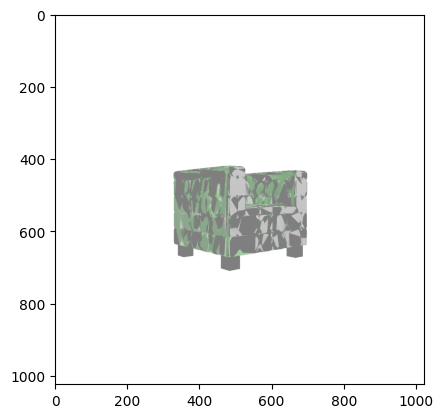

In [191]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from lib.data.preprocess_sketch import image_grid
from pytorch3d.structures import Meshes
from pytorch3d.io import load_obj, load_objs_as_meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    RasterizationSettings,
    OpenGLPerspectiveCameras,
    HardPhongShader,
    FoVPerspectiveCameras,
    Materials,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    TexturesVertex,
    PointLights,
)

# Load the obj file
path = "/home/borth/sketch2shape/data/siamese_chair_medium/1b5ab441fb8e3b1b450621b513a975bb/model_normalized.obj"
# path = "/home/borth/sketch2shape/data/cow_mesh/cow.obj"
obj = load_obj(path)

# Set up a simple perspective camera
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Extract vertices and faces from the loaded obj
vertices = obj[0].to(device)
faces = obj[1].verts_idx.to(device)
verts_rgb = torch.ones_like(vertices)[None]
textures = TexturesVertex(verts_features=verts_rgb.to(device))
mesh = Meshes(verts=[vertices], faces=[faces], textures=textures)
# mesh = Meshes(verts=[vertices], faces=[faces])
# if mesh.textures is None:
#     mesh.textures = TexturesVertex(
#         verts_features=torch.ones_like(mesh.verts_padded(), device=device)
#     )


# Initialize an OpenGL perspective camera.
R, T = look_at_view_transform(2, 1, 140)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
# im = []
# for i in np.linspace(-10, 10, 16):


# Change specular color to green and change material shininess
materials = Materials(device=device, specular_color=[[0.0, 1.0, 0.0]], shininess=1)

# Create a MeshRenderer
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=RasterizationSettings(
            image_size=1024,
            blur_radius=0,
            faces_per_pixel=1,
        ),
    ),
    shader=HardPhongShader(
        device=device,
        cameras=cameras,
        lights=PointLights(device=device, location=[[0.0, 1.0, 2.0]]),
    ),
)

images = renderer(mesh, materials=materials)[0, ..., :3].cpu().numpy()
plt.imshow(images)
plt.show()

In [ ]:
obj

In [146]:
verts, faces_idx, _ = load_obj(path, load_textures=False)
faces = faces_idx.verts_idx

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = TexturesVertex(verts_features=verts_rgb.to(device))

# Create a Meshes object
mesh = Meshes(
    verts=[verts.to(device)],
    faces=[faces.to(device)],
    # textures=textures
)

# Render the plotly figure
fig = plot_scene({"subplot1": {"cow_mesh": mesh}})
fig.show()

In [141]:
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj

--2023-12-02 18:28:19--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 52.222.236.74, 52.222.236.65, 52.222.236.117, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|52.222.236.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330659 (323K) [text/plain]
Saving to: ‘data/cow_mesh/cow.obj’

cow.obj             100%[===================>] 322,91K  --.-KB/s    in 0,03s   

2023-12-02 18:28:20 (10,0 MB/s) - ‘data/cow_mesh/cow.obj’ saved [330659/330659]



In [ ]:
from pytorch3d.datasets import ShapeNetCore